In [1]:
# 🛠️ Step 1: Install dependencies
!pip install gluonts mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 987.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.2

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Cluster files.zip to Cluster files.zip


In [2]:
import zipfile
import os

# Replace 'your_folder.zip' with the actual name of your zip file
zip_path = '/content/Cluster files.zip'
extract_path = 'Cluster_Files'  # This will be the folder name after extraction

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Optional: list contents to confirm
print("Contents:")
print(os.listdir(extract_path))


Contents:
['Cluster files']


In [3]:
# -------------------- PART 1: DEEPAR MODEL --------------------

# Install required packages (run this once in your environment)
# !pip install gluonts==0.11.5 mxnet==1.9.1

import os
import pandas as pd
import numpy as np
import json
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import StudentTOutput
from gluonts.evaluation.backtest import make_evaluation_predictions

# Parameters
DATA_FOLDER = "/content/Cluster_Files/Cluster files"  # Update to your folder name
freq = "D"
prediction_length = 30
context_length = 60
ma_window = 7
epochs = 30
learning_rate = 5e-4

residual_windows = []

# Loop over each cluster
for cluster_id in range(10):
    file_path = os.path.join(DATA_FOLDER, f"cluster_{cluster_id}.csv")
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    df["date"] = df["InvoiceDate"].dt.date
    daily = df.groupby("date")["TotalSales"].sum().reset_index()
    daily["date"] = pd.to_datetime(daily["date"]).sort_values()

    # Moving average target
    daily["MovingAvgSales"] = daily["TotalSales"].rolling(window=ma_window, min_periods=1).mean()
    sales = daily["MovingAvgSales"].values

# Use only training portion for computing min and max
    train_sales = sales[:-prediction_length]
    min_val, max_val = train_sales.min(), train_sales.max()

# Apply train-based scaling to entire data (train + test)
    scaled_sales = (sales - min_val) / (max_val - min_val + 1e-8)

    # Time features
    dates = daily["date"]
    day_of_week = dates.dt.dayofweek / 6.0
    month = (dates.dt.month - 1) / 11.0
    rolling = pd.Series(scaled_sales).rolling(window=7, min_periods=1).mean().values

    # Static features
    avg_sales = np.mean(sales)
    std_sales = np.std(sales)
    zero_ratio = np.sum(sales == 0) / len(sales)

    # Split
    train_target = scaled_sales[:-prediction_length]
    test_target = sales[-prediction_length:]
    start_date = daily["date"].iloc[0]

    train_entry = {
        "start": start_date,
        "target": train_target.tolist(),
        "feat_static_real": [avg_sales, std_sales, zero_ratio],
        "feat_dynamic_real": [
            day_of_week.values[:-prediction_length].tolist(),
            month.values[:-prediction_length].tolist(),
            rolling[:-prediction_length].tolist()
        ]
    }

    train_ds = ListDataset([train_entry], freq=freq)

    # Train DeepAR
    estimator = DeepAREstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=context_length,
        num_cells=30,
        num_layers=1,
        dropout_rate=0.1,
        cell_type="gru",
        distr_output=StudentTOutput(),
        use_feat_dynamic_real=True,
        use_feat_static_real=True,
        trainer=Trainer(epochs=epochs, learning_rate=learning_rate),
    )

    predictor = estimator.train(training_data=train_ds)

    # Forecast and compute residual
    forecast_it, _ = make_evaluation_predictions(
        dataset=train_ds, predictor=predictor, num_samples=100
    )

    forecast = list(forecast_it)[0]
    scaled_pred = forecast.mean
    unscaled_pred = scaled_pred * (max_val - min_val + 1e-8) + min_val
    residual = test_target - unscaled_pred

    residual_windows.append({
        "cluster": cluster_id,
        "deepar_pred": unscaled_pred.tolist(),
        "actual": test_target.tolist(),
        "residual": residual.tolist()
    })

# Save residuals for Transformer training
with open("residual_windows.json", "w") as f:
    json.dump(residual_windows, f)

print("✅ Saved residual_windows.json — Ready for Transformer training")

100%|██████████| 50/50 [00:04<00:00, 10.36it/s, epoch=30/30, avg_epoch_loss=-1.78]


✅ Saved residual_windows.json — Ready for Transformer training


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 3516709.3014
Epoch 2, Loss: 3469860.9001
Epoch 3, Loss: 3469142.0299
Epoch 4, Loss: 3493149.7786
Epoch 5, Loss: 3471036.3112
Epoch 6, Loss: 6893598.4779
Epoch 7, Loss: 3469583.5397
Epoch 8, Loss: 3491137.5091
Epoch 9, Loss: 3467691.9645
Epoch 10, Loss: 3468026.3773
Epoch 11, Loss: 3469475.3451
Epoch 12, Loss: 3475731.9896
Epoch 13, Loss: 3475610.0160
Epoch 14, Loss: 3468046.5934
Epoch 15, Loss: 3468486.8369
Epoch 16, Loss: 3467997.3053
Epoch 17, Loss: 6891770.2214
Epoch 18, Loss: 3485087.0931
Epoch 19, Loss: 3474855.2409
Epoch 20, Loss: 3484586.7318
Epoch 21, Loss: 3492647.2357
Epoch 22, Loss: 3468888.7350
Epoch 23, Loss: 3484990.4948
Epoch 24, Loss: 3485382.4792
Epoch 25, Loss: 6897555.3682
Epoch 26, Loss: 3484492.3086
Epoch 27, Loss: 3469281.9896
Epoch 28, Loss: 3469256.4596
Epoch 29, Loss: 3484482.1120
Epoch 30, Loss: 6873762.2360
Epoch 31, Loss: 6874604.0078
Epoch 32, Loss: 3474700.7682
Epoch 33, Loss: 3469557.2233
Epoch 34, Loss: 3485289.3542
Epoch 35, Loss: 6881593

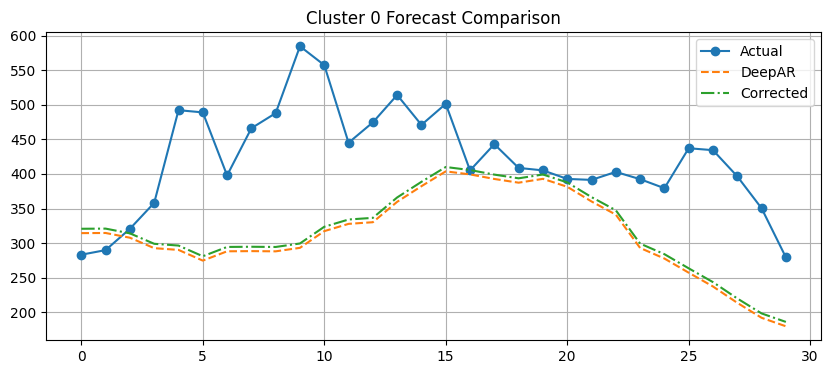

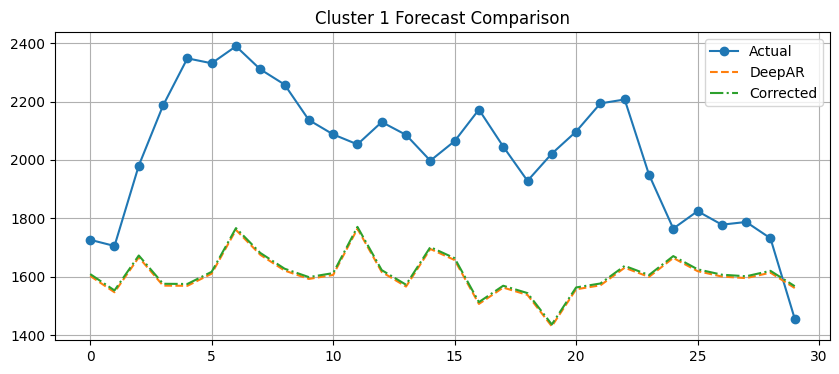

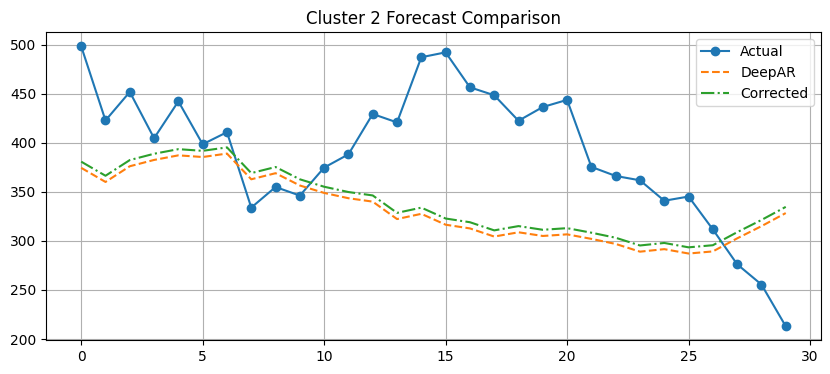

In [4]:
# -------------------- MODIFIED TRANSFORMER MODEL FOR RESIDUAL CORRECTION --------------------

import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# -------------------- Dataset --------------------

with open("residual_windows.json", "r") as f:
    data = json.load(f)

class ResidualDataset(Dataset):
    def __init__(self, data):
        self.X = []
        self.y = []
        for d in data:
            if len(d["deepar_pred"]) == 30 and len(d["residual"]) == 30:
                self.X.append(d["deepar_pred"])
                self.y.append(d["residual"])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ResidualDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# -------------------- Positional Encoding --------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# -------------------- Residual Transformer Model --------------------

class ResidualTransformer(nn.Module):
    def __init__(self, seq_len=30, d_model=64, nhead=4, num_layers=3):
        super(ResidualTransformer, self).__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # (B, 30, 1)
        x = self.input_proj(x)  # (B, 30, d_model)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # (30, B, d_model)
        x = self.transformer(x)  # (30, B, d_model)
        x = x.permute(1, 0, 2)  # (B, 30, d_model)
        x = self.output_proj(x).squeeze(-1)  # (B, 30)
        return x

# -------------------- Training --------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transformer = ResidualTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

model_transformer.train()
for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model_transformer(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# -------------------- Evaluation --------------------

model_transformer.eval()
corrected_mapes = {}

for d in data:
    x = torch.tensor(d["deepar_pred"], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        correction = model_transformer(x).squeeze(0).cpu().numpy()
    corrected_forecast = np.array(d["deepar_pred"]) + correction
    actual = np.array(d["actual"])
    mape = mean_absolute_percentage_error(actual, corrected_forecast)
    corrected_mapes[f"Cluster {d['cluster']}"] = round(mape * 100, 2)

print("\n📊 Final MAPE after Enhanced Transformer Residual Correction:")
for cluster, mape in sorted(corrected_mapes.items()):
    print(f"{cluster}: {mape}%")

# -------------------- Visualization --------------------

for d in data[:3]:
    x = torch.tensor(d["deepar_pred"], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        correction = model_transformer(x).squeeze(0).cpu().numpy()
    corrected = np.array(d["deepar_pred"]) + correction
    plt.figure(figsize=(10, 4))
    plt.plot(d["actual"], label="Actual", marker='o')
    plt.plot(d["deepar_pred"], label="DeepAR", linestyle='--')
    plt.plot(corrected, label="Corrected", linestyle='-.')
    plt.title(f"Cluster {d['cluster']} Forecast Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# -------------------- PATCHTST FOR RESIDUAL CORRECTION --------------------

import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------

with open("residual_windows.json", "r") as f:
    data = json.load(f)

class ResidualDataset(Dataset):
    def __init__(self, data):
        self.X = []
        self.y = []
        for d in data:
            if len(d["deepar_pred"]) == 30 and len(d["residual"]) == 30:
                self.X.append(d["deepar_pred"])
                self.y.append(d["residual"])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ResidualDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# -------------------- Patch Embedding + PatchTST --------------------

class PatchEmbedding(nn.Module):
    def __init__(self, patch_len=10, in_channels=1, d_model=64):
        super().__init__()
        self.patch_len = patch_len
        self.proj = nn.Conv1d(in_channels, d_model, kernel_size=patch_len, stride=patch_len)

    def forward(self, x):
        # x: (B, L, 1)
        x = x.permute(0, 2, 1)  # (B, 1, L)
        x = self.proj(x)        # (B, d_model, num_patches)
        x = x.permute(0, 2, 1)  # (B, num_patches, d_model)
        return x

class PatchTST(nn.Module):
    def __init__(self, input_len=30, patch_len=10, d_model=64, nhead=4, num_layers=2, pred_len=30):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_len=patch_len, d_model=d_model)
        self.pos_enc = nn.Parameter(torch.randn(1, input_len // patch_len, d_model))  # learnable
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear((input_len // patch_len) * d_model, pred_len)
        )

    def forward(self, x):  # x: (B, 30, 1)
        x = self.patch_embed(x) + self.pos_enc  # (B, P, d_model)
        x = x.permute(1, 0, 2)  # (P, B, d_model)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (B, P, d_model)
        return self.decoder(x)  # (B, pred_len)

In [6]:
# -------------------- Training --------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_patchtst = PatchTST().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_patchtst.parameters(), lr=1e-3)

model_patchtst.train()
for epoch in range(30):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = model_patchtst(batch_x)  # (B, 30)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 3482501.5677
Epoch 2, Loss: 3482794.5794
Epoch 3, Loss: 6885802.6693
Epoch 4, Loss: 6902009.2305
Epoch 5, Loss: 3481392.5322
Epoch 6, Loss: 3496830.3438
Epoch 7, Loss: 3474344.8913
Epoch 8, Loss: 3470512.2176
Epoch 9, Loss: 3472233.4342
Epoch 10, Loss: 3488396.5326
Epoch 11, Loss: 6902228.1921
Epoch 12, Loss: 3470499.6953
Epoch 13, Loss: 6877258.6976
Epoch 14, Loss: 3470850.0033
Epoch 15, Loss: 3486069.0625
Epoch 16, Loss: 6881271.5807
Epoch 17, Loss: 3474618.2282
Epoch 18, Loss: 3475558.4596
Epoch 19, Loss: 3488990.6810
Epoch 20, Loss: 3464868.7201
Epoch 21, Loss: 3482332.6484
Epoch 22, Loss: 6867506.9896
Epoch 23, Loss: 3463202.0501
Epoch 24, Loss: 3479681.2188
Epoch 25, Loss: 3479108.7799
Epoch 26, Loss: 6880599.6895
Epoch 27, Loss: 3460669.6217
Epoch 28, Loss: 3483206.7552
Epoch 29, Loss: 3475882.2057
Epoch 30, Loss: 3482381.7240


In [7]:
# -------------------- Evaluation --------------------

model_patchtst.eval()
corrected_mapes = {}

for d in data:
    x = torch.tensor(d["deepar_pred"], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        correction = model_patchtst(x).squeeze(0).cpu().numpy()
    corrected_forecast = np.array(d["deepar_pred"]) + correction
    actual = np.array(d["actual"])
    mape = mean_absolute_percentage_error(actual, corrected_forecast)
    corrected_mapes[f"Cluster {d['cluster']}"] = round(mape * 100, 2)

print("\n📊 Final MAPE after PatchTST Residual Correction:")
for cluster, mape in sorted(corrected_mapes.items()):
    print(f"{cluster}: {mape}%")


📊 Final MAPE after PatchTST Residual Correction:
Cluster 0: 23.03%
Cluster 1: 19.63%
Cluster 2: 17.21%
Cluster 3: 46.51%
Cluster 4: 34.95%
Cluster 5: 48.56%
Cluster 6: 53.67%
Cluster 7: 38.16%
Cluster 8: 25.74%
Cluster 9: 23.95%


In [8]:
!pip install einops

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[1, 3, 5]):
        super(InceptionBlock, self).__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, k), padding=(0, k//2))
            for k in kernel_sizes
        ])
        self.conv1x1 = nn.Conv2d(len(kernel_sizes) * out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        outs = [branch(x) for branch in self.branches]
        out = torch.cat(outs, dim=1)
        out = self.conv1x1(out)
        return out

class TimesBlock(nn.Module):
    def __init__(self, in_channels, out_channels, top_k=3):
        super(TimesBlock, self).__init__()
        self.top_k = top_k
        self.inception = InceptionBlock(in_channels, out_channels)

    def forward(self, x):
        # x: (B, T, C)
        B, T, C = x.size()
        x_fft = torch.fft.rfft(x, dim=1)
        freq = torch.abs(x_fft).mean(dim=(0, 2))
        freq[0] = 0  # Remove DC component
        topk = torch.topk(freq, self.top_k).indices
        periods = (T / topk.cpu().numpy()).astype(int)

        res = []
        for p in periods:
          if T % p != 0:
            pad_len = p - (T % p)
            x_padded = F.pad(x, (0, 0, 0, pad_len))
          else:
            x_padded = x
          B_p, T_p, C_p = x_padded.size()
          x_reshaped = x_padded.view(B_p, T_p // p, p, C_p)
          x_reshaped = x_reshaped.permute(0, 3, 1, 2)  # (B, C, T//p, p)
          out = self.inception(x_reshaped)
          out = out.mean(dim=2)  # Average over segments
          out = out.permute(0, 2, 1)  # (B, p, C)
          out = out.reshape(B, -1, C)

    # 🔧 Fix shape mismatch
          if out.size(1) > T:
            out = out[:, :T, :]
          elif out.size(1) < T:
            pad = T - out.size(1)
            out = F.pad(out, (0, 0, 0, pad))  # pad on time dimension
          res.append(out)

        out = sum(res) / len(res)
        return out

class TimesNet(nn.Module):
    def __init__(self, input_dim=1, d_model=64, num_blocks=3, top_k=3):
        super(TimesNet, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.blocks = nn.ModuleList([
            TimesBlock(d_model, d_model, top_k=top_k) for _ in range(num_blocks)
        ])
        self.projection = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, T)
        x = x.unsqueeze(-1)  # (B, T, 1)
        x = self.embedding(x)  # (B, T, d_model)
        for block in self.blocks:
            x = x + block(x)
        out = self.projection(x).squeeze(-1)  # (B, T)
        return out

In [10]:
import json
from torch.utils.data import Dataset, DataLoader

class ResidualDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.X = []
        self.y = []
        for d in data:
            pred = d['deepar_pred']
            actual = d['actual']
            if len(pred) == len(actual):
                residual = [a - p for a, p in zip(actual, pred)]
                self.X.append(pred)
                self.y.append(residual)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Initialize dataset and dataloader
dataset = ResidualDataset('residual_windows.json')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_timesnet = TimesNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_timesnet.parameters(), lr=1e-3)

model_timesnet.train()
for epoch in range(20):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model_timesnet(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1, Loss: 3457310.2500
Epoch 2, Loss: 2191213.7500
Epoch 3, Loss: 2012534.6250
Epoch 4, Loss: 873931.5000
Epoch 5, Loss: 822497.1250
Epoch 6, Loss: 1138463.6250
Epoch 7, Loss: 1135279.2500
Epoch 8, Loss: 854815.3750
Epoch 9, Loss: 581332.5625
Epoch 10, Loss: 499406.7188
Epoch 11, Loss: 583988.6250
Epoch 12, Loss: 642199.6875
Epoch 13, Loss: 560025.0625
Epoch 14, Loss: 413481.5312
Epoch 15, Loss: 325209.5938
Epoch 16, Loss: 339222.9375
Epoch 17, Loss: 406673.3125
Epoch 18, Loss: 444329.0938
Epoch 19, Loss: 412428.6875
Epoch 20, Loss: 340605.3750


In [12]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Load data for evaluation
with open('residual_windows.json', 'r') as f:
    data = json.load(f)

model_timesnet.eval()
corrected_mapes = {}
cluster_mapes = {}

for d in data:
    pred = torch.tensor(d['deepar_pred'], dtype=torch.float32).unsqueeze(0).to(device)
    actual = np.array(d['actual'])
    with torch.no_grad():
        correction = model_timesnet(pred).squeeze(0).cpu().numpy()
    corrected = np.array(d['deepar_pred']) + correction
    mape = mean_absolute_percentage_error(actual, corrected)
    cluster = d['cluster']
    if cluster not in cluster_mapes:
        cluster_mapes[cluster] = []
    cluster_mapes[cluster].append(mape)

# Compute average MAPE per cluster
for cluster, mapes in cluster_mapes.items():
    corrected_mapes[f"Cluster {cluster}"] = round(np.mean(mapes) * 100, 2)

# Display results
print("\n📊 Final MAPE after TimesNet Residual Correction:")
for cluster, mape in corrected_mapes.items():
    print(f"{cluster}: {mape}%")


📊 Final MAPE after TimesNet Residual Correction:
Cluster 0: 41.58%
Cluster 1: 50.81%
Cluster 2: 65.28%
Cluster 3: 18.63%
Cluster 4: 21.76%
Cluster 5: 8.74%
Cluster 6: 41.59%
Cluster 7: 15.73%
Cluster 8: 106.84%
Cluster 9: 36.86%



📊 Final MAPE after Per‑Cluster Model Selection:
Cluster 0: 41.58%
Cluster 1: 19.63%
Cluster 2: 17.21%
Cluster 3: 18.63%
Cluster 4: 21.76%
Cluster 5: 8.74%
Cluster 6: 57.48%
Cluster 7: 15.73%
Cluster 8: 25.74%
Cluster 9: 25.47%


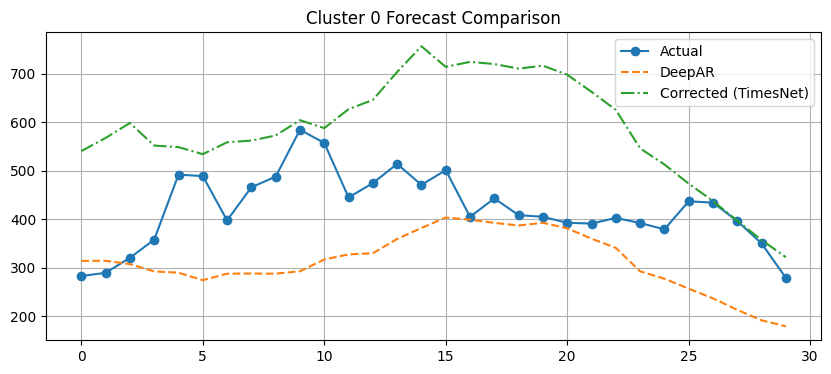

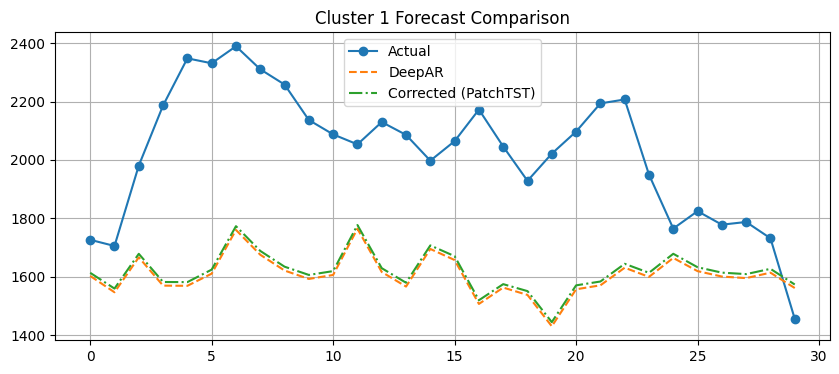

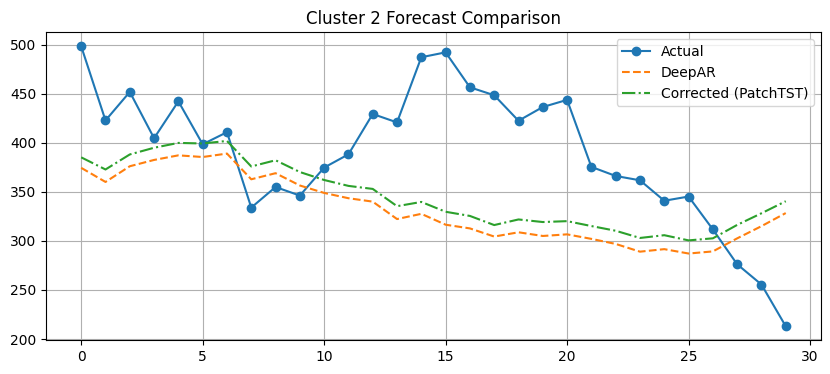

In [13]:
# -------------------- ENSEMBLE FORECASTER: BEST MODEL PER CLUSTER --------------------

import torch, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# -------------------- LOAD JSON --------------------
with open("residual_windows.json", "r") as f:
    data = json.load(f)

# -------------------- LOAD TRAINED MODELS --------------------
# (Assume you have variables: model_transformer, model_patchtst, model_timesnet)
models = {
    "Transformer": model_transformer,
    "PatchTST":    model_patchtst,
    "TimesNet":    model_timesnet
}

# -------------------- BEST MODEL PER CLUSTER --------------------
best_model_per_cluster = {
    "0": "TimesNet",
    "1": "PatchTST",
    "2": "PatchTST",
    "3": "TimesNet",
    "4": "TimesNet",
    "5": "TimesNet",
    "6": "Transformer",
    "7": "TimesNet",
    "8": "PatchTST",
    "9": "Transformer"
}

# -------------------- DEVICE --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for m in models.values():
    m.eval(); m.to(device)

# -------------------- HELPER: BUILD INPUT PER MODEL --------------------
def make_input(base, model_name):
    """
    base: 1‑D tensor (T,)
    returns tensor on correct device with shape:
        Transformer → (1, T)
        PatchTST    → (1, T, 1)
        TimesNet    → (1, T)   (TimesNet adds channel internally)
    """
    if model_name == "Transformer":
        return base.unsqueeze(0)                         # (1, T)
    elif model_name == "PatchTST":
        return base.unsqueeze(0).unsqueeze(-1)           # (1, T, 1)
    else:  # TimesNet
        return base.unsqueeze(0)                         # (1, T)

# -------------------- EVALUATION --------------------
ensemble_mapes = {}

for entry in data:
    cluster_id       = str(entry["cluster"])
    model_name       = best_model_per_cluster[cluster_id]
    model            = models[model_name]
    base_tensor      = torch.tensor(entry["deepar_pred"], dtype=torch.float32).to(device)
    x_input          = make_input(base_tensor, model_name)

    with torch.no_grad():
        correction   = model(x_input).squeeze(0).cpu().numpy()

    corrected_fc     = np.array(entry["deepar_pred"]) + correction
    actual           = np.array(entry["actual"])
    mape             = mean_absolute_percentage_error(actual, corrected_fc)
    ensemble_mapes[f"Cluster {cluster_id}"] = round(mape * 100, 2)

# -------------------- OUTPUT --------------------
print("\n📊 Final MAPE after Per‑Cluster Model Selection:")
for cluster, val in sorted(ensemble_mapes.items()):
    print(f"{cluster}: {val}%")

# -------------------- OPTIONAL: PLOT COMPARISONS --------------------
for entry in data[:3]:
    cid        = str(entry["cluster"])
    mname      = best_model_per_cluster[cid]
    model      = models[mname]
    base_x     = torch.tensor(entry["deepar_pred"], dtype=torch.float32).to(device)
    x_inp      = make_input(base_x, mname)

    with torch.no_grad():
        corr   = model(x_inp).squeeze(0).cpu().numpy()

    corrected = np.array(entry["deepar_pred"]) + corr

    plt.figure(figsize=(10,4))
    plt.plot(entry["actual"],        label="Actual",    marker='o')
    plt.plot(entry["deepar_pred"],   label="DeepAR",    ls='--')
    plt.plot(corrected,              label=f"Corrected ({mname})", ls='-.')
    plt.title(f"Cluster {cid} Forecast Comparison")
    plt.legend(); plt.grid(True); plt.show()


📊 MAPE per Cluster for Each Model:

🔹 Transformer:
  Cluster 0: 24.23%
  Cluster 1: 19.93%
  Cluster 2: 18.04%
  Cluster 3: 47.57%
  Cluster 4: 41.22%
  Cluster 5: 48.62%
  Cluster 6: 57.48%
  Cluster 7: 38.67%
  Cluster 8: 24.97%
  Cluster 9: 25.47%

🔹 PatchTST:
  Cluster 0: 23.03%
  Cluster 1: 19.63%
  Cluster 2: 17.21%
  Cluster 3: 46.51%
  Cluster 4: 34.95%
  Cluster 5: 48.56%
  Cluster 6: 53.67%
  Cluster 7: 38.16%
  Cluster 8: 25.74%
  Cluster 9: 23.95%

🔹 TimesNet:
  Cluster 0: 41.58%
  Cluster 1: 50.81%
  Cluster 2: 65.28%
  Cluster 3: 18.63%
  Cluster 4: 21.76%
  Cluster 5: 8.74%
  Cluster 6: 41.59%
  Cluster 7: 15.73%
  Cluster 8: 106.84%
  Cluster 9: 36.86%


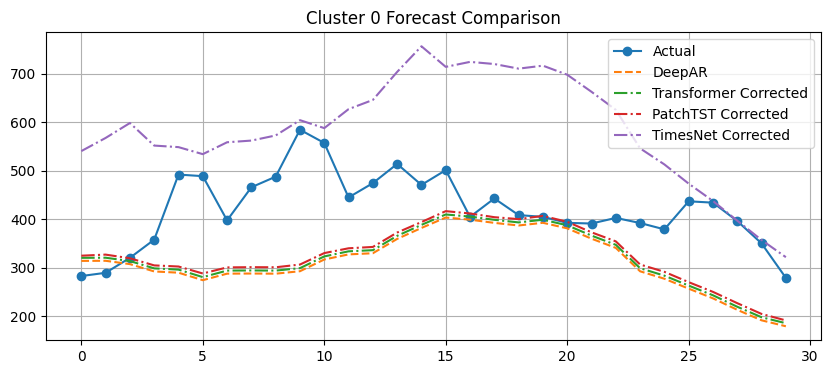

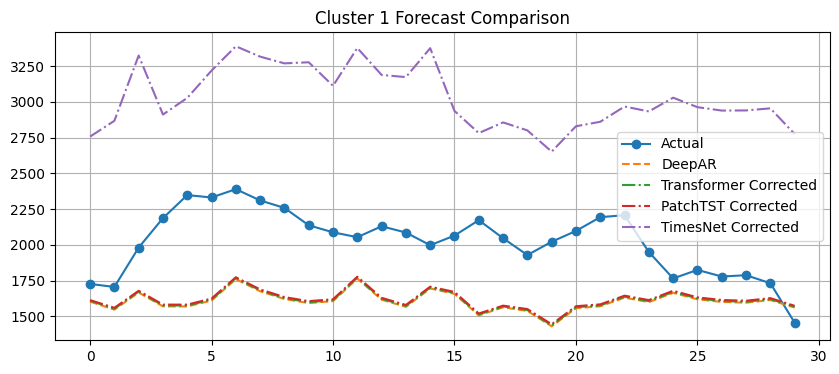

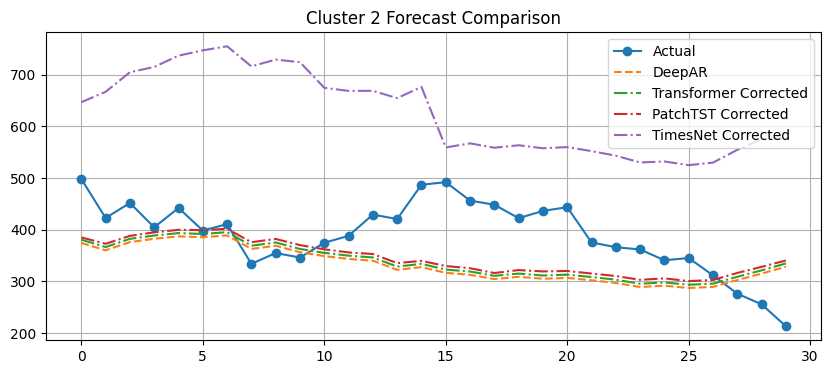

In [14]:
# -------------------- ENSEMBLE FORECASTER: ALL MODELS PER CLUSTER --------------------

import torch, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# -------------------- LOAD JSON --------------------
with open("residual_windows.json", "r") as f:
    data = json.load(f)

# -------------------- LOAD TRAINED MODELS --------------------
models = {
    "Transformer": model_transformer,
    "PatchTST":    model_patchtst,
    "TimesNet":    model_timesnet
}

# -------------------- DEVICE --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for m in models.values():
    m.eval(); m.to(device)

# -------------------- HELPER: BUILD INPUT PER MODEL --------------------
def make_input(base, model_name):
    if model_name == "Transformer":
        return base.unsqueeze(0)                         # (1, T)
    elif model_name == "PatchTST":
        return base.unsqueeze(0).unsqueeze(-1)           # (1, T, 1)
    else:  # TimesNet
        return base.unsqueeze(0)                         # (1, T)

# -------------------- EVALUATION --------------------
model_mapes = {name: {} for name in models.keys()}

for entry in data:
    cluster_id  = str(entry["cluster"])
    actual      = np.array(entry["actual"])
    base_tensor = torch.tensor(entry["deepar_pred"], dtype=torch.float32).to(device)

    for model_name, model in models.items():
        x_input = make_input(base_tensor, model_name)
        with torch.no_grad():
            correction = model(x_input).squeeze(0).cpu().numpy()
        corrected_fc = np.array(entry["deepar_pred"]) + correction
        mape = mean_absolute_percentage_error(actual, corrected_fc)
        if cluster_id not in model_mapes[model_name]:
            model_mapes[model_name][cluster_id] = []
        model_mapes[model_name][cluster_id].append(mape)

# -------------------- OUTPUT --------------------
print("\n📊 MAPE per Cluster for Each Model:")
for model_name in models:
    print(f"\n🔹 {model_name}:")
    for cid in sorted(model_mapes[model_name]):
        avg_mape = np.mean(model_mapes[model_name][cid]) * 100
        print(f"  Cluster {cid}: {avg_mape:.2f}%")

# -------------------- OPTIONAL: PLOT COMPARISONS --------------------
for entry in data[:3]:
    cid    = str(entry["cluster"])
    actual = entry["actual"]
    base   = np.array(entry["deepar_pred"])
    plt.figure(figsize=(10, 4))
    plt.plot(actual, label="Actual", marker='o')
    plt.plot(base,   label="DeepAR", linestyle='--')
    for model_name in models:
        model = models[model_name]
        x = torch.tensor(base, dtype=torch.float32).to(device)
        x_inp = make_input(x, model_name)
        with torch.no_grad():
            correction = model(x_inp).squeeze(0).cpu().numpy()
        corrected = base + correction
        plt.plot(corrected, label=f"{model_name} Corrected", linestyle='-.')
    plt.title(f"Cluster {cid} Forecast Comparison")
    plt.legend(); plt.grid(True); plt.show()



📊 Final MAPE after DeepAR ➝ Transformer ➝ TimesNet:
Cluster 0: 5.11%
Cluster 1: 2.96%
Cluster 2: 3.89%
Cluster 3: 6.63%
Cluster 4: 6.19%
Cluster 5: 6.48%
Cluster 6: 7.84%
Cluster 7: 4.89%
Cluster 8: 5.62%
Cluster 9: 3.47%


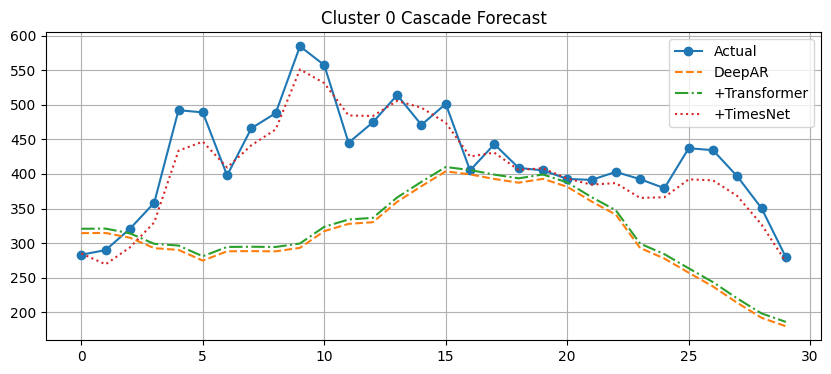

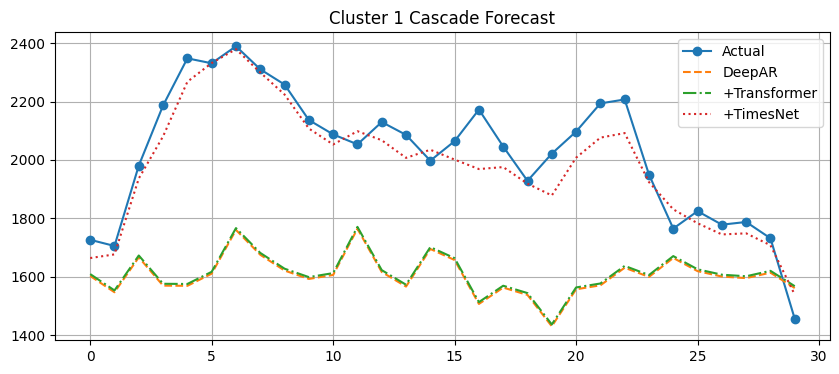

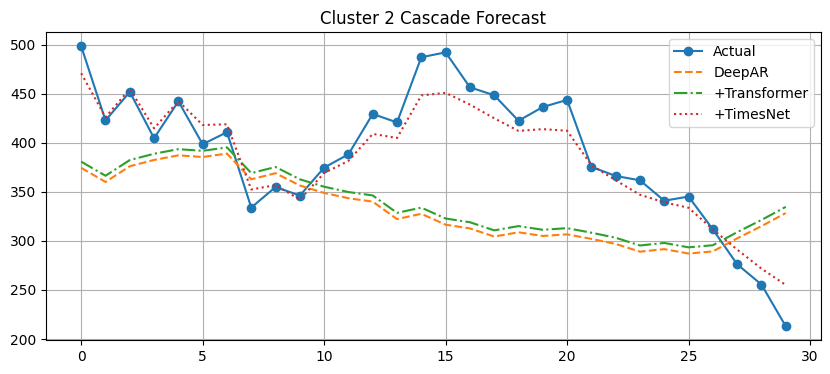

In [15]:
import torch, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

with open("residual_windows.json", "r") as f:
    data = json.load(f)

models = {
    "Transformer": model_transformer,
    "TimesNet": model_timesnet,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for m in models.values():
    m.eval(); m.to(device)

def make_input(x, model_name):
    if model_name == "Transformer":
        return x.unsqueeze(0)  # (1, T)
    else:
        return x.unsqueeze(0)

final_mapes = {}

for entry in data:
    cluster = str(entry["cluster"])
    y_pred  = np.array(entry["deepar_pred"])
    y_true  = np.array(entry["actual"])
    x       = torch.tensor(y_pred, dtype=torch.float32).to(device)

    x_t1 = make_input(x, "Transformer")
    with torch.no_grad():
        r1 = models["Transformer"](x_t1).squeeze(0).cpu().numpy()
    corrected1 = y_pred + r1

    r2_input = torch.tensor(y_true - corrected1, dtype=torch.float32).to(device)
    x_t2 = make_input(r2_input, "TimesNet")
    with torch.no_grad():
        r2 = models["TimesNet"](x_t2).squeeze(0).cpu().numpy()
    final_forecast = corrected1 + r2

    mape = mean_absolute_percentage_error(y_true, final_forecast)
    final_mapes[f"Cluster {cluster}"] = round(mape * 100, 2)

print("\n📊 Final MAPE after DeepAR ➝ Transformer ➝ TimesNet:")
for cluster, mape in sorted(final_mapes.items()):
    print(f"{cluster}: {mape}%")

for entry in data[:3]:
    cid     = str(entry["cluster"])
    actual  = np.array(entry["actual"])
    y_pred  = np.array(entry["deepar_pred"])
    x       = torch.tensor(y_pred, dtype=torch.float32).to(device)

    with torch.no_grad():
        x1 = make_input(x, "Transformer")
        r1 = models["Transformer"](x1).squeeze(0).cpu().numpy()
        corrected1 = y_pred + r1

        x2 = make_input(torch.tensor(actual - corrected1, dtype=torch.float32).to(device), "TimesNet")
        r2 = models["TimesNet"](x2).squeeze(0).cpu().numpy()
        final = corrected1 + r2

    plt.figure(figsize=(10, 4))
    plt.plot(actual, label="Actual", marker='o')
    plt.plot(y_pred, label="DeepAR", linestyle='--')
    plt.plot(corrected1, label="+Transformer", linestyle='-.')
    plt.plot(final, label="+TimesNet", linestyle=':')
    plt.title(f"Cluster {cid} Cascade Forecast")
    plt.legend(); plt.grid(True); plt.show()
